In [1]:
# import packages
library(tidyverse)
library(tidymodels)
library(knitr)
library(repr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
# set the seed
set.seed(1)
# load data and data wrangling
heart <- read_csv("processed.cleveland.data", col_names = FALSE)
colnames(heart) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                     "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
heart <- heart |>
    mutate(disease = as.factor(case_when(num == 0 ~ 'no', num > 0 ~ 'yes'))) |>
    mutate(sex = as.factor(sex), cp = as.factor(cp), fbs = as.factor(fbs),
           restecg = as.factor(restecg), exang = as.factor(exang), slope = as.factor(slope),
           ca = as.numeric(ca), thal = as.factor(thal), num = as.factor(num))
heart[heart == "?"] <- NA
# remove missing values
heart <- na.omit(heart)
head(heart)
summary(heart)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `ca = as.numeric(ca)`.
Caused by warning:
! NAs introduced by coercion”


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,disease
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6.0,0,no
67,1,4,160,286,0,2,108,1,1.5,2,3,3.0,2,yes
67,1,4,120,229,0,2,129,1,2.6,2,2,7.0,1,yes
37,1,3,130,250,0,0,187,0,3.5,3,0,3.0,0,no
41,0,2,130,204,0,2,172,0,1.4,1,0,3.0,0,no
56,1,2,120,236,0,0,178,0,0.8,1,0,3.0,0,no


      age        sex     cp         trestbps          chol       fbs    
 Min.   :29.00   0: 96   1: 23   Min.   : 94.0   Min.   :126.0   0:254  
 1st Qu.:48.00   1:201   2: 49   1st Qu.:120.0   1st Qu.:211.0   1: 43  
 Median :56.00           3: 83   Median :130.0   Median :243.0          
 Mean   :54.54           4:142   Mean   :131.7   Mean   :247.4          
 3rd Qu.:61.00                   3rd Qu.:140.0   3rd Qu.:276.0          
 Max.   :77.00                   Max.   :200.0   Max.   :564.0          
 restecg    thalach      exang      oldpeak      slope         ca        
 0:147   Min.   : 71.0   0:200   Min.   :0.000   1:139   Min.   :0.0000  
 1:  4   1st Qu.:133.0   1: 97   1st Qu.:0.000   2:137   1st Qu.:0.0000  
 2:146   Median :153.0           Median :0.800   3: 21   Median :0.0000  
         Mean   :149.6           Mean   :1.056           Mean   :0.6768  
         3rd Qu.:166.0           3rd Qu.:1.600           3rd Qu.:1.0000  
         Max.   :202.0           Max.   :6.20

In [3]:
# split data
heart_split <- initial_split(heart, prop = 0.75, strata = disease)  
heart_train <- training(heart_split)   
heart_test <- testing(heart_split)
head(heart_train)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,disease
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6.0,0,no
37,1,3,130,250,0,0,187,0,3.5,3,0,3.0,0,no
41,0,2,130,204,0,2,172,0,1.4,1,0,3.0,0,no
57,1,4,140,192,0,0,148,0,0.4,2,0,6.0,0,no
56,0,2,140,294,0,2,153,0,1.3,2,0,3.0,0,no
57,1,3,150,168,0,0,174,0,1.6,1,0,3.0,0,no


In [4]:
# data summary
heart_summary <- heart_train |>
                 group_by(disease) |>
                 summarize(observations = n(), mean_age = mean(age), mean_trestbps = mean(trestbps),mean_chol = mean(chol))
heart_summary

disease,observations,mean_age,mean_trestbps,mean_chol
<fct>,<int>,<dbl>,<dbl>,<dbl>
no,120,52.57500,128.8417,245.3750
yes,102,56.84314,136.5000,248.6176


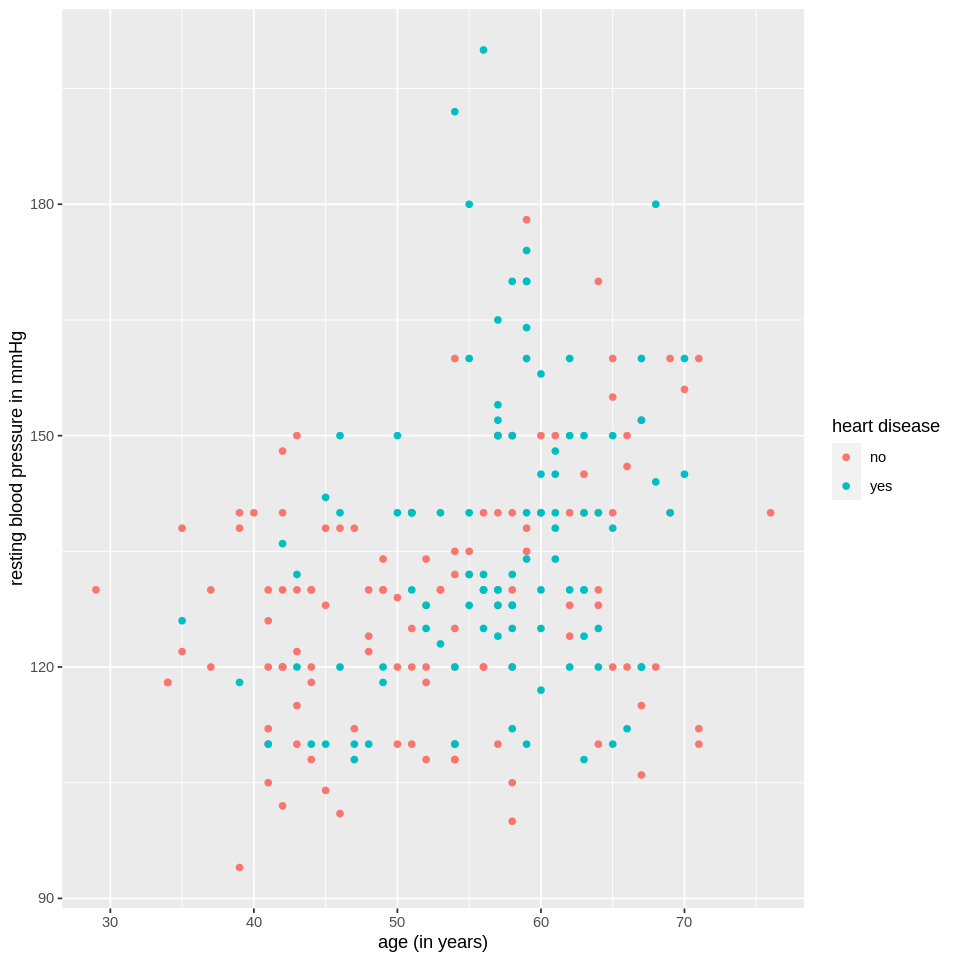

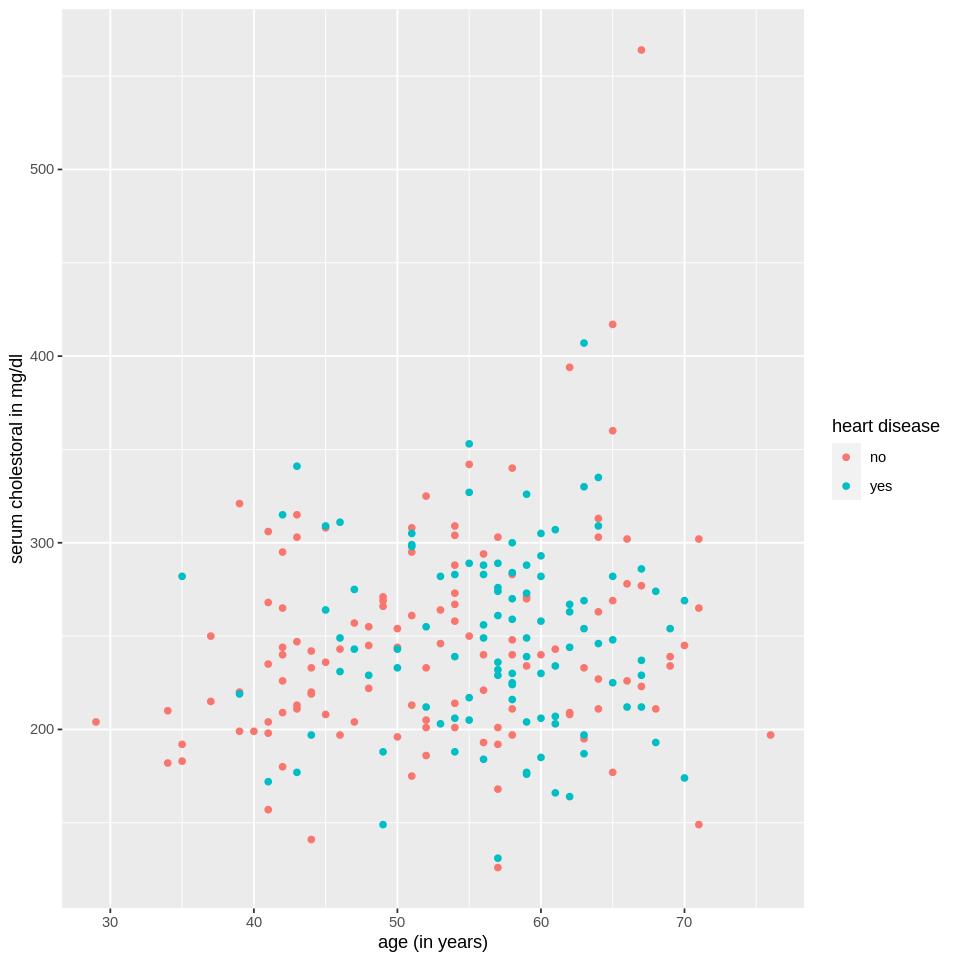

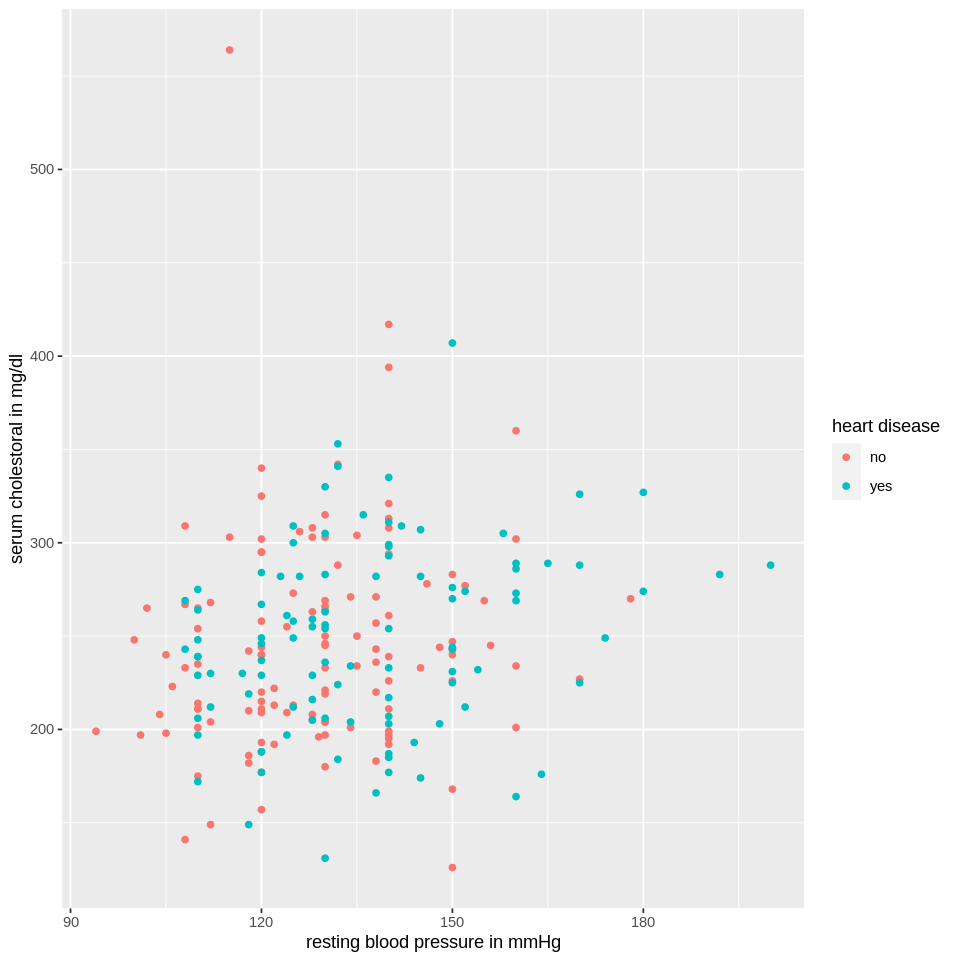

In [5]:
#age_trestbps_plot
options(repr.plot.width = 8, repr.plot.height = 8)
age_trestbps_plot <- heart_train |>
      ggplot(aes(x = age, y = trestbps, color = disease)) +
      geom_point()+
labs(x = "age (in years)", y = "resting blood pressure in mmHg", color = "heart disease")
age_trestbps_plot

#age_chol_plot
options(repr.plot.width = 8, repr.plot.height = 8)
age_chol_plot <- heart_train |>
      ggplot(aes(x = age, y = chol , color = disease)) +
      geom_point()+
labs(x = "age (in years)", y = "serum cholestoral in mg/dl", color = "heart disease")
age_chol_plot

#trestbps_chol_plot
options(repr.plot.width = 8, repr.plot.height = 8)
trestbps_chol_plot <- heart_train |>
      ggplot(aes(x = trestbps, y = chol, color = disease)) +
      geom_point()+
labs(x = "resting blood pressure in mmHg", y = "serum cholestoral in mg/dl", color = "heart disease")
trestbps_chol_plot